In [16]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [247]:
# read in all the words
words = open('../data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [18]:
len(words)

32033

In [19]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
# build the dataset

block_size = 3 # context length : how many characters do we take to predict the next one?

X,Y = [], []
for w in words:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)  
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X) # context, encoded
Y = torch.tensor(Y)

In [54]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [148]:
# build the dataset

def build_dataset(words):
    block_size = 3 # context length : how many characters do we take to predict the next one?
    X,Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)  
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X) 
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])      # training set
Xdev, Ydev = build_dataset(words[n1:n2])  # dev=validation set
Xte, Yte = build_dataset(words[n2:])      # test set

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [146]:
n1

25626

In [55]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])

In [56]:
# 가중치
C = torch.randn((27,2))

In [57]:
C[5]

tensor([ 1.3402, -0.0789])

In [58]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([ 1.3402, -0.0789])

In [59]:
C[[5,6,7]]

tensor([[ 1.3402, -0.0789],
        [-0.1854, -1.0349],
        [ 0.2324, -0.9970]])

In [60]:
C[X].shape

torch.Size([228146, 3, 2])

In [61]:
emb = C[X] # same as lookup table
emb.shape

torch.Size([228146, 3, 2])

In [62]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)   

In [63]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
h.shape

torch.Size([228146, 100])

In [64]:
# why .view() is efficient?
# each tensor has 'storage' 1 dimensional vector
# .view manipulate storage, not modify 'storage'
'''
a = torch.arange(18)
a.storage()
'''

'\na = torch.arange(18)\na.storage()\n'

In [65]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [66]:
logits = h @ W2 + b2 

In [67]:
counts = logits.exp()

In [68]:
prob = counts / counts.sum(1, keepdim=True)

In [69]:
prob.shape

torch.Size([228146, 27])

In [19]:
# ----- now made respectable :) -----

In [149]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182437, 3]), torch.Size([182437]))

In [150]:
seed_num = 2147483647
g = torch.Generator().manual_seed(seed_num)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100,generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27,generator=g)
parameters = [C,W1,b1,W2,b2]

In [151]:
sum(p.nelement() for p in parameters) # number of parameters in total

# .nelement : Returns the total number of elements in the input tensor.

3481

In [152]:
for p in parameters:
    p.requires_grad = True

why we use `F.cross_entropy` functions?

1. efficiency. Pytorch wll cluster up all these operations
2. backward pass can be made much more efficient.
3. numerical well behaved

In [153]:
lre = torch.linspace(-3,0 ,1000)
lrs = 10**lre

In [164]:
lri = []
lossi = []
for i in range(10000):  

    # minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(32,)) 

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
    logits= h @ W2 + b2 # (32,27)
    loss = F.cross_entropy(logits, Ytr[ix]) 
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.01
    # when we're at the late stages of training potentially, we can do one learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())
# print(loss.item())

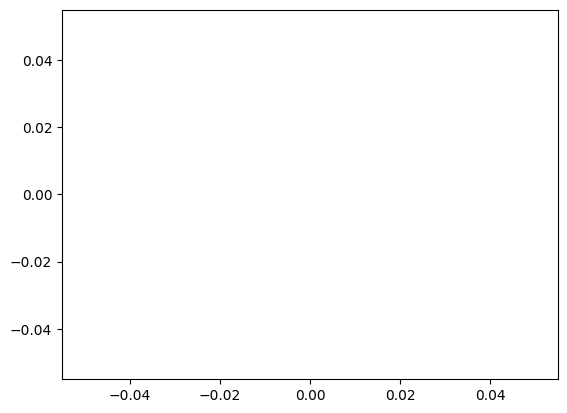

In [155]:
# finding good learning rate
# lri : i번째 학습률
# lossi : i 번째 손실
plt.plot(lri, lossi)

# -1, 즉 10의 -1인 0.1 부분이 좋다.

In [166]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
logits= h @ W2 + b2 # (32,27)
loss = F.cross_entropy(logits, Ytr) 
loss

tensor(2.3266, grad_fn=<NllLossBackward0>)

### validation

In [165]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
logits= h @ W2 + b2 # (32,27)
loss = F.cross_entropy(logits, Ydev) 
loss

tensor(2.3453, grad_fn=<NllLossBackward0>)

## make larger hidden layer

In [220]:
seed_num = 2147483647
g = torch.Generator().manual_seed(seed_num)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30,200), generator=g)
b1 = torch.randn(200,generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn(27,generator=g)
parameters = [C,W1,b1,W2,b2]

In [221]:
sum(p.nelement() for p in parameters)

11897

In [222]:
for p in parameters:
    p.requires_grad = True

In [201]:
lre = torch.linspace(-3,0 ,1000)
lrs = 10**lre

In [ ]:
lri = []
lossi = []
stepi = []

In [239]:

for i in range(50000):  

    # minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(32,)) 

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32,100)
    logits= h @ W2 + b2 # (32,27)
    loss = F.cross_entropy(logits, Ytr[ix]) 
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.01
    # when we're at the late stages of training potentially, we can do one learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
# print(loss.item())

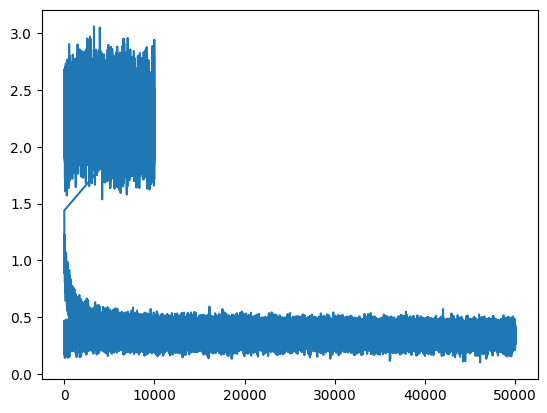

In [240]:
# finding good learning rate
# lri : i번째 학습률
# lossi : i 번째 손실
plt.plot(stepi, lossi)

# graph had quite a bit of thickness to this, that's because we are optimizing over these mini batches, and mini batches create a little bit noise.

In [241]:
# is it overfitting?
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32,100)
logits= h @ W2 + b2 # (32,27)
loss = F.cross_entropy(logits, Ytr) 
loss

tensor(2.1395, grad_fn=<NllLossBackward0>)

### validation

In [242]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32,100)
logits= h @ W2 + b2 # (32,27)
loss = F.cross_entropy(logits, Ydev) 
loss

tensor(2.1896, grad_fn=<NllLossBackward0>)

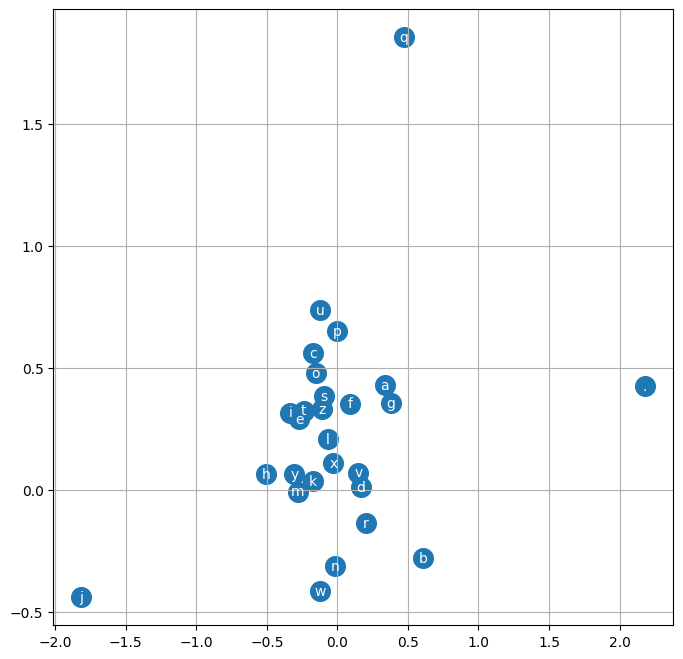

In [243]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(),itos[i],ha='center',va='center',color='white')
plt.grid('minor')

## another way, differ learning rate

In [ ]:

for i in range(200000):  

    # minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(32,)) 

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32,100)
    logits= h @ W2 + b2 # (32,27)
    loss = F.cross_entropy(logits, Ytr[ix]) 
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
# print(loss.item())

### sample from the model

In [244]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1, block_size,d)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

mora.
kayah.
seen.
nihayah.
rethruthadraege.
zeredielin.
shivaelle.
elissopharleit.
kollya.
cayshabergiaz.
jest.
jairenderlenteron.
ubumted.
ryyah.
fael.
yumajahsalyan.
hal.
salynn.
ufeuna.
lujuren.
